# Digital Holographic Refocusing
Written by Kristina Monakhova for BioE168 Fall 2017

Simple digital refocusing using a Fresnel Kernel based on Goodman's Fourier Optics.  You can specify the image path, system parameters, and the desired defocus distance.  This script will refocus the image for you and show you an animation of the refocusing. There are two different modes to run this simulation:  Experimental or Simulated.

#### Experimental:
Place your defocused image in the images folder and change 'image_path' to link to your image.  Change 'focused_path' to link to your focused image for comparison.  Change the system parameters to match your microscope setup. Change 'z_defocus_guess' to match how much you think your image is defocused (um). The simulation will refocus your image by z_defocus_guess, show a focus metric based on an L1 norm, and play an animation showing your defocused image coming into focus

#### Simulated:
Place an image that you would like to propagate in the images folder and link to your image in 'simulated_image_path'.  Change 'z_defocus_guess' to the amount (um) that you would like to defocus by.  The simualation will propgate your desired image by this amount and show an animation of this propagation.  

### Initializations

In [2]:
%matplotlib inline                         
import numpy as np                         # Numpy 
import matplotlib.pyplot as plt            # For making figures
import numpy.fft as fft                    # FFTs
from scipy import misc
from scipy import ndimage
import myfunctions as mf                   # Custom functions

### Options

In [48]:
# Define Image paths: 
image_path = 'images/laserTarget_8.tif'
focused_path = 'images/laserTarget_0.tif'
simulated_image_path = 'images/testdog.png'

# Options
mode = 'Experimental'          # Modes: 'Simulated' or 'Experimental'
determine_best_focus = False    # Find the best focal plane

# System parameters 
d_pix = 5.4             # um/pixel (on camera sensor)
M = 8.0                 # System magnification 
dx = d_pix/M            # um/pixel with magnification 
lmda = 0.530            # wavelength of light (um) 
k = 2.0*np.pi/lmda      # wave number 
z_defocus_guess = 317.0 # defocus (um)
zs = np.zeros(1); zs[0] = z_defocus_guess

### Read in Files and Digitally Refocus

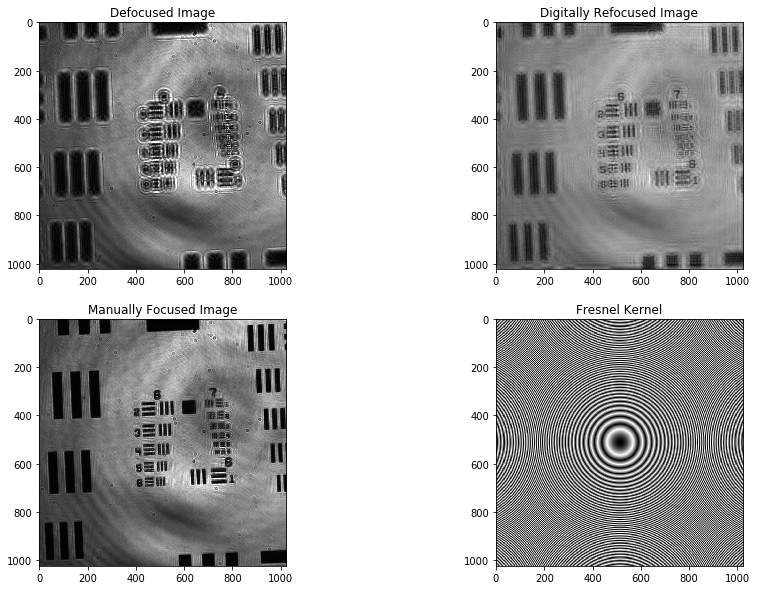

In [49]:
# Read in Images   
if mode == 'Experimental':
    image = mf.rgb2gray(np.double(misc.imread(image_path)))            # Read in defocused image
    i_focused = mf.rgb2gray(np.double(misc.imread(focused_path)))      # Read in focused image

    # Crop image to square 
    N_size = image.shape[0]; x1 = 0; y1 = 0;                           # Starting index for image cropping 
    i_crop = image[x1:x1+N_size,y1:y1+N_size]
    i_fcrop = i_focused[x1:x1+N_size,y1:y1+N_size]
    
    g_in = np.sqrt(i_crop)                                             # complex field is the sqrt of the image
    [g_out,H, f_metric] = mf.propagate(g_in, lmda, zs, dx)             # Propagate field 

    # Plot results
    f, axs = plt.subplots(2,2,figsize=(15,10))
    plt.subplot(2,2,1); plt.imshow(i_crop, cmap='gray'); 
    plt.title('Defocused Image');
    plt.subplot(2,2,2); plt.imshow(np.abs(g_out[:,:,0]), cmap='gray'); 
    plt.title('Digitally Refocused Image');
    plt.subplot(2,2,3); plt.imshow(i_fcrop, cmap='gray'); 
    plt.title('Manually Focused Image');
    plt.subplot(2,2,4); plt.imshow(np.abs(np.angle(H[:,:,0])), cmap='gray'); 
    plt.title('Fresnel Kernel');
    
elif mode == 'Simulated':
    g_in = mf.rgb2gray(np.double(misc.imread(simulated_image_path)))   # Read in image
    [g_out,H, f_metric] = mf.propagate(g_in, lmda, zs, dx)             # Propagate field by zs
    
    # Plot results
    f, axs = plt.subplots(1,2,figsize=(15,10))
    plt.subplot(1,2,1); plt.imshow(g_in, cmap='gray'); 
    plt.title('Original Field');
    plt.subplot(1,2,2); plt.imshow(np.abs(g_out[:,:,0]), cmap='gray'); 
    plt.title('Propagated Field');

In [50]:
# Sweep different focus distances to determine the best focus
if determine_best_focus == True:

    zs = np.arange(z_defocus_guess-15, z_defocus_guess+15, 1)
    [g_out,H, f_metric] = mf.propagate(g_in, lmda, zs, dx)

    plt.plot(zs, np.abs(f_metric)/np.max(np.abs(f_metric)));
    plt.title('Focus Metric');
    plt.xlabel('Decfocus distance (um)');

    z_focus = zs[np.argmax(f_metric)]
    print('The best focus distance is: ', z_focus)
    

## Play animation showing defocus 

In [51]:
dz = 5.0                                                  # Step size for z sweep 
zs = np.arange(0.0, z_defocus_guess, dz)                  # z distances for animation 
[g_out,H, f_metric] = mf.propagate(g_in, lmda, zs, dx)    # Propagate field 
mf.interactive_slider(np.abs(g_out), 'Fresnel')           # Make interactie slider

In [52]:
mf.imshowAnim(np.abs(g_out), zs, g_out.shape[2], 5) # Make video